<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;a:link{color: white}">
    <h1 style='color:GhostWhite;'>Part 1: Should This Loan be Approved or Denied ?</h1>

An XGBoost v1.6+ data model to predict whether a loan can be approved or denied.

Optuna hyperparameter tuning for the XGBoost model is in Part 2 => <a style="color:yellow" href="https://www.kaggle.com/code/josephramon/sba-optuna-xgboost-random-forest">Part 2</a><br>
    </div>

<div class="alert alert-block alert-success">  
    <b>Dataset Source</b><br>
    <a href="https://www.kaggle.com/mirbektoktogaraev/should-this-loan-be-approved-or-denied">U.S. Small Business Administration (SBA) Dataset</a> - all information about the dataset can be found at this link<br><br>    

<b>Related Notebooks:</b><br>
    <a href= "https://www.kaggle.com/code/josephramon/sba-optuna-xgboost-random-forest">Part 2: SBA Optuna XGBoost, Random Forest</a><br>
    <a href= "https://www.kaggle.com/code/josephramon/sba-keras-binary-classification-and-optuna">Part 3: SBA Keras Binary Classification, Optuna, Keras Tuner</a><br><br>
If interested, Data Exploratory Visualization in Tableau for this dataset can also be seen at :<br>
    <a href= "https://public.tableau.com/app/profile/joseph8038/viz/SBADatasetVisualizationandAnalysis/SBADatasetVisualizationandAnalysis-StoryBoard">SBA Data Exploratory Visualization in Tableau</a>
</div>

<div class="alert alert-block alert-info" style="color:DarkSlateBlue">
This notebook is divided into 2 main parts:<br>
<ul>
<li><a style="color:DarkSlateGrey;" href="#part1"><b>1. Pipeline</b></a> - this is the end result encapsulated into a pipeline</li><br>
<li><a style="color:DarkSlateGrey" href="#part2"><b>2. Data Exploration (EDA) and Preparation, Modeling, Metrics</b></a> - from start to end, with some notes</li>
</ul>
"Our model results are way more dependent on how well feature engineering is performed than on the model itself. Machine Learning models are like very skilled linguists that can decipher any text in any language. However, it will not be helpful if they are handed a bunch of scribbles or blurred out text. EDA should not be skipped, as a thorough EDA and feature engineering process accounts for 90% of the results of a good model."<br><br>
One method of avoiding memory leaks is doing processing inside a function. It creates a new scope for the intermediate variables and removes them automatically when the interpreter exits the function; hence, most of the code below are encapsulated into functions for this purpose. 
</div>

<div class="alert alert-block alert-success" style="color:DarkSlateBlue">
<b>Evaluation Metrics:</b><br><br>
<b>Our dataset is imbalanced</b> with regards to the target feature, a ratio of about 4.6:1.  One approach to correct this is to resample data, either undersample or oversample.  We will demonstate an example using undersampling where the metric we will evaluate is <b>accuracy</b>, but most of the rest will be oversampling.<br><br>
    When we oversample, the main metric that we will evaluate is the <b>f1_score</b>, and look into <b>precision, recall sensitivity, and recall specificity</b> as well.<br><br>
What costs more for the business, the model being wrong about granting loans, or wrong about denying loans ?<br><br>
I think it would be more preferable to have a <b>high precision and recall sensitivity, and consequently a high f1_score</b>, where the <b>model predicts a loan to be approved</b> (positive class).  There will be false positives of course, but it will be minimized to a small percentage, and confidence that the model is correct is higher.
<br><br>
When the model flags a loan as "deny", whether a valid prediction or a false negative, it will be reviewed further anyway.
</div>

<a id="toc"></a>
<h2>Table Of Contents</h2>
<ul>
    <li><a style="color:DarkSlateGrey" href="#paths_and_flags">Paths and Flags</a></li>
    <li><a style="color:DarkSlateGrey" href="#libraries">Libraries</a></li>   
    <li><a style="color:DarkSlateGrey" href="#custom_functions">Custom Functions</a></li>
    <li><a style="color:DarkSlateGrey" href="#custom_classes">Custom Classes</a></li>
    <li><a style="color:DarkSlateGrey" href="#xgboost_class">XGBoost Class</a></li>
    <br>
    <li><a style="color:DarkSlateGrey" href="#part1">Part 1. PipeLine</a></li>
    <ul>
        <li><a style="color:DarkSlateGrey" href="#pl_classes">Pipeline Classes</a></li>
        <li><a style="color:DarkSlateGrey" href="#load_pl_df">Load Dataset for PipeLine</a></li>
        <li><a style="color:DarkSlateGrey" href="#pl_run">Run the pipeline</a></li>
    </ul>
    <br>
    <li><a style="color:DarkSlateGrey" href="#part2">Part 2. Data Exploration and Preparation, Modeling, Metrics</a></li>
    <ul>
        <li><a style="color:DarkSlateGrey" href="#de_load_df">Load Dataset</a></li>
        <li><a style="color:DarkSlateGrey" href="#dep">Data Exploration / Preparation</a></li>
        <li><a style="color:DarkSlateGrey" href="#build_model">Build Model Using XGBoost</a></li>
        <ul>
            <li><a style="color:DarkSlateGrey" href="#model1">Model v1</a></li>
            <li><a style="color:DarkSlateGrey" href="#model2">Model v2 : Undersample</a></li>
            <li><a style="color:DarkSlateGrey" href="#model3">Model v3 : Oversample</a></li>
        </ul>
        <li><a style="color:DarkSlateGrey" href="#test_model">Test Model</a></li>
        <ul>
            <li><a style="color:DarkSlateGrey" href="#test_test_dataset">Test Model With Test Dataset</a></li>
           <li><a style="color:DarkSlateGrey" href="#test_user_input">Test Model With User Input</a></li>
        </ul>
        <li><a style="color:DarkSlateGrey" href="#mutual_info">Mutual Information Scores</a></li>
        <li><a style="color:DarkSlateGrey" href="#trim_datasets">Trim Datasets</a></li>
        <li><a style="color:DarkSlateGrey" href="#results1">Full or Trimmed Dataset</a></li>
    </ul>  
    <br>
    <li><a style="color:DarkSlateGrey;font-size:18px" href="https://www.kaggle.com/code/josephramon/sba-optuna-xgboost-random-forest" target="_blank">Optuna Hyperparameter Tuning - <i style='font-size:13px'>this will open a new browser tab</i></a></li>
</ul>

<a id="paths_and_flags"></a>
<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Paths and Flags</b></div>

In [30]:
import os
'''
kaggle_flag :
   0 - if running outside Kaggle (e.g. Jupyter Notebook), change inputdir & workdir to your 
       own path
   1 - if running as a Kaggle notebook
'''
# Change this logic to your own if needed
if os.path.exists('../usr/lib/myfuncs/myfuncs.py'):
    kaggle_flag = 1
    print('Running a Kaggle notebook')
else:
    kaggle_flag = 0
    print('Not running a Kaggle notebook')
    
# alert_flag - change to 0 for no sound alert, 1 for sound alert after long running cells
alert_flag = 0

# GPU is automatically detected if activated

#---------------------------------------------------------------------------------------#

if kaggle_flag == 1:             # Kaggle
    inputdir  = "../input/should-this-loan-be-approved-or-denied/"
    workdir  = "./"
    final_ds  = '../input/sba-xgboost-model/sba_final.csv.feather'  
    final_csv = '../input/sba-xgboost-model/sba_final.csv'          
    functions_path = "../usr/lib/myfuncs/myfuncs.py"
else:
    inputdir  = "C:\\Python\\Python_Data_Science_Exercises\\datasets\\"
    workdir  = "C:\\Python\\Python_Data_Science_Exercises\\datasets\\"
    final_ds  = f'{workdir}sba_final.csv.feather'
    final_csv = f'{workdir}sba_final.csv'
    functions_path = 'C:\\Python\\Python_Data_Science_Exercises\\mylibs\\'

audio_path="https://www.soundjay.com/misc/sounds/tablet-bottle-1.mp3" # for alert

print(f'kaggle_flag : {kaggle_flag}')
print(f'alert_flag  : {alert_flag}')

Not running a Kaggle notebook
kaggle_flag : 0
alert_flag  : 0


<a id="libraries"></a>
<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Libraries</b></div>

In [31]:
# to be able to use clear_output(wait=True)
from IPython.display import clear_output 

def install_packages():
    print('Please wait, package installations started, if needed')
    libs = ['scikit-learn', 'seaborn', 'numpy','matplotlib', 'tensorflow','torch','joblib',
            'psutil','imbalanced-learn','xgboost','pyttsx3', 'pandas-profiling','sweetviz']
    
    piplist = !pip3 list
    for i in range(len(libs)):
        if not piplist.grep(libs[i]):
            !pip3 install {libs[i]}
        #
        # Since XGBoost version must be at least 1.6 for our code to work properly, 
        # we upgrade it here if needed, before we import it
        #
        elif libs[i] == 'xgboost':
            s = (piplist.grep('xgboost'))[0]
            s = " ".join(s.split())
            ver = s.split(" ")
            if ver[1] < '1.6':
                !pip3 install --upgrade xgboost
            
    clear_output(wait=True)
    print('Package installations completed')

install_packages()

Package installations completed


In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pyttsx3
from IPython.display import Audio, display
from IPython.display import FileLink
from IPython.display import IFrame
from IPython.core.display import HTML
import hashlib
import copy                     # for deepcopy()
import datetime as dt
import gc
from pandas_profiling import ProfileReport
import sweetviz as sv
import shutil
import psutil
import os
import sys

import joblib
import torch             # for clearing GPU cache
from time import sleep
import importlib

import xgboost
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
'''
We can use these other packages for oversampling, or combined over/under sampling, 
but they are super slow with large datasets.  It will take 7 to 8 hours just for our 
X_train dataset
''' 
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
#from imblearn.over_sampling import ADASYN
#from imblearn.combine import SMOTETomek

from collections import Counter
from sklearn.model_selection import train_test_split

%matplotlib inline

warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

clear_output(wait=True)
print('Package imports completed')

Package imports completed


In [4]:
'''
This check is mainly for Kaggle which has an older version of XGBoost, as at Apr 2022

XGBoost version should be at least 1.6.  From XGBoost 1.6, early_stopping_rounds and 
eval_metric are now under hyperparameters, and deprecated from fit() method.
'''
assert xgboost.__version__ >= '1.6',\
    "XGBoost version must be at least 1.6. RESTART KERNEL if already upgraded."

print(f'XGBoost __Version__ : {xgboost.__version__} is good.')
print()
!pip3 show xgboost

XGBoost __Version__ : 1.6.1 is good.

Name: xgboost
Version: 1.6.1
Summary: XGBoost Python Package
Home-page: https://github.com/dmlc/xgboost
Author: 
Author-email: 
License: Apache-2.0
Location: c:\programdata\anaconda3\lib\site-packages
Requires: numpy, scipy
Required-by: autoxgb


<a id="custom_functions"></a>
<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Custom Functions</b></div>

In [5]:
sys.path

['C:\\Python\\Python_Data_Science_Exercises',
 'C:\\ProgramData\\Anaconda3\\python38.zip',
 'C:\\ProgramData\\Anaconda3\\DLLs',
 'C:\\ProgramData\\Anaconda3\\lib',
 'C:\\ProgramData\\Anaconda3',
 '',
 'C:\\Users\\latri\\AppData\\Roaming\\Python\\Python38\\site-packages',
 'C:\\ProgramData\\Anaconda3\\lib\\site-packages',
 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\win32',
 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\win32\\lib',
 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\Pythonwin']

In [6]:
# import custom functions
# rerun this cell if any changes are made to myfuncs.py during the current session

if functions_path not in sys.path:
    sys.path.append(functions_path)
import myfuncs as mf
importlib.reload(mf)      # in case changes were made to myfuncs during current session
print('Custom functions import completed')

Custom functions import completed


<div class="alert alert-block alert-info">
<b>Some custom functions and classes in <a style="color:ForestGreen" href="https://www.kaggle.com/code/josephramon/myfuncs" target="_blank">myfuncs.py</a></b>.  Not all are used in this notebook; and those used are called with a qualification "<b>mf.</b>".<br>  
In Kaggle, myfuncs.py is set up as a <b>Utility Script</b> in /usr/lib<br>
<ul>
    <li>is_kaggle_gpu_enabled()</li>
<li>clear_gpu(tree_method='gpu_hist')</li>
<li>reduce_mem_usage(df, print_info = True, use_float16=False)</li>
<li>runtime(rt1,rt2)</li>
<li>create_download_link(title = "Download ", filename = "data.csv")</li>
<li>GetRam()</li>
<li>convertFloatToDecimal(f=0.0, precision=2)</li>
<li>formatFileSize(size, sizeIn, sizeOut, precision=0)</li>
<li>check_cols_with_nulls(df)</li>
<li>check_infinity_nan(df, dfname)</li>
<li>fixvals(val)</li>
<li>model_eval(y_valid,predictions, cmDisplay=False)</li>
<li>model_eval2(model, X_train, y_train, X_testdata, y_testdata,
    cmDisplay=False, prtstr = 'y_valid', multi_label = False)</li>
<li>plot_features(booster, figsize)</li>
<li>make_mi_scores(X, y)</li>
<li>plot_mi_scores(scores)</li>
<li>GetSweetVizReport(df, workdir, kaggle_flag)</li>
<li>SetVoice(kaggle_flag)</li>
<li>InitTPUStrategy()</li>
<li>ZipDir(zippath)</li>
<li>GetTimeZone()</li>
<li>GetRatio(num1, num2)</li>
<li>class color</li>
</div>

In [7]:
# ensure garbage collector is enabled
(gc.isenabled() == False) and gc.enable();

In [8]:
gpu_enabled = mf.is_kaggle_gpu_enabled()

if gpu_enabled == False:
    tree_method = 'hist'
else:
    tree_method = 'gpu_hist'

del gpu_enabled
gc.collect()

sleep(5)
clear_output(wait=True)
tree_method

'hist'

In [9]:
''' 
Set up voice object.  Used in different areas of notebook to indicate completion of long processes.
'''
engine = mf.SetVoice(kaggle_flag)

In [10]:
'''Uncomment if rapids is to be installed

# Install rapids
%time
print('Please wait ... it takes time to set up rapids')
!cp ../input/rapids/rapids.21.06 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
sys.path = ["/opt/conda/envs/rapids/lib/python3.7/site-packages"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib/python3.7"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib"] + sys.path 
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/
clear_output(wait=True)
print('rapids environment has been set')

'''

'Uncomment if rapids is to be installed\n\n# Install rapids\n%time\nprint(\'Please wait ... it takes time to set up rapids\')\n!cp ../input/rapids/rapids.21.06 /opt/conda/envs/rapids.tar.gz\n!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null\nsys.path = ["/opt/conda/envs/rapids/lib/python3.7/site-packages"] + sys.path\nsys.path = ["/opt/conda/envs/rapids/lib/python3.7"] + sys.path\nsys.path = ["/opt/conda/envs/rapids/lib"] + sys.path \n!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/\nclear_output(wait=True)\nprint(\'rapids environment has been set\')\n\n'

<i><a style="color:DarkSlateGrey" href="#toc">Back to Table Of Contents</a></i>

<a id="custom_classes"></a>
<div style="font-family: Trebuchet MS;background-color:PowderBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Custom Classes</b></div>

<a id="xgboost_class"></a>
<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>XGBoost Class</b></div>

In [26]:
class process_model():  
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.X_train, self.y_train = None, None
        self.X_valid, self.X_test = None, None
        self.y_valid, self.y_test = None, None
        
        self.xg_model = None
        
        '''
        Since we are using XGBoost, instead of resampling imbalanced data, we can also
        set the scale_pos_weight hyperparameter of XGBoost to indicate that the dataset has 
        a certain ratio of positive and negative classes and XGBoost will take care of the 
        rest. For example, if we have 40,000 positive and 2,000 negative samples, if we want 
        to train our XGBoost classifier on this dataset we would set the value of 
        scale_pos_weight to be 40,000/2,000 = 20.
        '''
        # this will be updated if we call the method upd_pos_weight below, after splitting data
        self.scale_pos_weight = 0
        
        print(f'MIS_Status Count ->  1 : {Counter(y)[1]}, 0 : {Counter(y)[0]}')

    def osample(self, print_info = True, os_data = [1,0,0], os_class = 'ros'):
        '''
        #Resampling method
        os_data:
            os_data[0] : 1 to resample train data; otherwise, 0 
            os_data[1] : 1 to resample valid data; otherwise, 0
            os_data[2] : 1 to resample test data; otherwise, 0
        ''' 
        # oversample
        if os_class == 'sm':
            resample = SMOTE(sampling_strategy='minority', n_jobs = -1, random_state=48)
        # combined over and under sampling
        elif os_class == 'sme':
            resample = SMOTEENN(sampling_strategy='minority', n_jobs = -1, random_state=48)
        # undersample
        elif os_class == 'rus':
            resample = RandomUnderSampler(sampling_strategy='majority', random_state=48)
        # oversample
        else:
            resample = RandomOverSampler(sampling_strategy='minority', random_state=48) 
        
        rt1=dt.datetime.now()
            
        if print_info == True:
            print()
            print('X_train size : ', len(self.X_train))
            print('X_valid size : ', len(self.X_valid))
            print('X_test size  : ', len(self.X_test))
            
        # fit and apply the transform
        print()
        if os_data[0] == 1:
            print(f'{mf.color.bdgreen}Please wait, resampling train data{mf.color.end}')
            X_train_over, y_train_over = resample.fit_resample(self.X_train, self.y_train)
            
        if os_data[1] == 1:
            print(f'{mf.color.bdgreen}Please wait, resampling valid data{mf.color.end}')
            X_valid_over, y_valid_over = resample.fit_resample(self.X_valid, self.y_valid)
            
        if os_data[2] == 1:
            print(f'{mf.color.bdgreen}Please wait, resampling test data{mf.color.end}')
            X_test_over, y_test_over   = resample.fit_resample(self.X_test, self.y_test)

        # summarize class distribution
        if print_info == True:
            if os_data[0] == 1:
                print('\nBefore Resampling train -> 1 : {}, 0 : {}'.format(
                    Counter(self.y_train)[1], Counter(self.y_train)[0]))

                print('After Resampling  train -> 1 : {}, 0 : {}'.format(
                    Counter(y_train_over)[1], Counter(y_train_over)[0]))
            if os_data[1] == 1:
                print('\nBefore Resampling valid -> 1 : {}, 0 : {}'.format(
                    Counter(self.y_valid)[1], Counter(self.y_valid)[0]))

                print('After Resampling  valid -> 1 : {}, 0 : {}'.format(
                    Counter(y_valid_over)[1], Counter(y_valid_over)[0]))
            if os_data[2] == 1:
                print('\nBefore Resampling test -> 1 : {}, 0 : {}'.format(
                    Counter(self.y_test)[1], Counter(self.y_test)[0]))

                print('After Resampling  test -> 1 : {}, 0 : {}'.format(
                    Counter(y_test_over)[1], Counter(y_test_over)[0]))
  
        if os_data[0] == 1:
            self.X_train, self.y_train = X_train_over, y_train_over
            
        if os_data[1] == 1:
            self.X_valid, self.y_valid = X_valid_over, y_valid_over
            
        if os_data[2] == 1:
            self.X_test, self.y_test   = X_test_over, y_test_over
            
        print(f'\n{mf.color.bdblue}Resampling {mf.color.end}', end = '')
        rt2=dt.datetime.now()
        mf.runtime(rt1,rt2)
        
    # oversampling method
    def osample_Xy(self, print_info = True, os_class = 'ros'):
        print(f'{mf.color.bdgreen}Please wait, resampling data{mf.color.end}\n')
        # define oversampling strategy
        if os_class == 'ros':
            oversample = RandomOverSampler(sampling_strategy='minority') 
        else:
            oversample = RandomUnderSampler(sampling_strategy='majority')
            
        if print_info == True:
            print('X size : ', len(self.X))
            print('y size : ', len(self.y))
            
        # fit and apply the transform
        X_over, y_over = oversample.fit_resample(self.X, self.y)

        # summarize class distribution
        if print_info == True:
            print(f'Before Resampling -> 1 : {Counter(self.y)[1]}, 0 : {Counter(self.y)[0]}')
            print(f'After Resampling  -> 1 : {Counter(y_over)[1]}, 0 : {Counter(y_over)[0]}')
        
        # update X and y with the oversampled results 
        self.X = X_over
        self.y = y_over
    
    def split_data(self, X_size = 0.7):   
        # Split Data into Train:Validate:Test
        
        # train_size=X_size
        # In the first step, we will split the data in training and remaining dataset
        self.X_train, X_rem, self.y_train, y_rem = train_test_split(self.X, self.y,
                                        stratify=self.y, train_size = X_size, random_state=48) 

        # Now since we want the valid and test size to be equal,
        # we have to define valid_size=0.5 (that is 50% of remaining data)
        # test_size = 0.5

        self.X_valid, self.X_test, self.y_valid, self.y_test = train_test_split(X_rem,y_rem,
                                        stratify=y_rem, test_size=0.5, random_state=48)
        
        return {'X_train':self.X_train, 'y_train':self.y_train,
                'X_valid':self.X_valid, 'y_valid':self.y_valid,
                'X_test':self.X_test, 'y_test':self.y_test}
    
    def split_data2(self, X_size = 0.8):   
        # Split Data into Train:Validate only
        
        # train_size=X_size
        self.X_train, self.X_valid, self.y_train, self.y_valid = train_test_split(
                self.X, self.y, stratify=self.y, train_size = X_size, random_state=48) 
        self.X_test, self.y_test = None, None

        return {'X_train':self.X_train, 'y_train':self.y_train,
                'X_valid':self.X_valid, 'y_valid':self.y_valid,
                'X_test':self.X_test, 'y_test':self.y_test}

    
    # Method to update scale_pos_weight
    def upd_pos_weight(self):
        if len(self.X_train) > 0:
            # negative / positive
            self.scale_pos_weight = Counter(self.y)[0] / Counter(self.y)[1]
        
        
    # Method to run model 
    # desc - description of metrics report
    def prep_run_model(self, desc='Metrics', cmDisplay=False, PipeLine_flag = False,
                hyperparams = {'n_estimators': 1000, 'learning_rate': 0.05, 'max_depth': 6,
                               'tree_method':tree_method, 'early_stopping_rounds':100,
                               'eval_metric':['auc','error']},
                               prt_acc = False):
        
        if self.scale_pos_weight > 0:
            hyperparams['scale_pos_weight'] = self.scale_pos_weight
            display(hyperparams)
            
        # from XGBoost 1.6, early_stopping_rounds and eval_metric are now under parameters,
        # and deprecated from fit() method.
        # The default hyperparameters are conservative, to help avoid overfitting
        
        print()
        print(f"{mf.color.bold}Please wait, Fitting model can take time ...{mf.color.end}")
        
        '''
        XGBRegressor is for continuous target/outcome variables. These are often called 
        "regression problems."

        XGBClassifier is for categorical target/outcome variables. These are often called 
        "classification problems."
        '''
        
        if PipeLine_flag == True:
            # hyperparams is a result of Optuna hyperparameter tuning
            # the hyperparameters lean towards being conservative to help avoid overfitting   
            hyperparams = {  'tree_method': 'hist',
                             'lambda': 0.0015806212781916517,
                             'alpha': 0.02036885802457707,
                             'gamma': 0,
                             'colsample_bytree': 0.6,
                             'subsample': 0.7,
                             'learning_rate': 0.1,
                             'n_estimators': 1000,
                             'max_depth': 13,
                             'random_state': 48,
                             'min_child_weight': 1,
                             'early_stopping_rounds': 100.0,
                             'eval_metric': ['auc', 'error']}
            
        self.xg_model = XGBClassifier(**hyperparams,use_label_encoder =False)
       
        #eval_setparam = [(self.X_train, self.y_train), (self.X_valid, self.y_valid)]
        eval_setparam = [(self.X_valid, self.y_valid)]
        
        self.xg_model.fit(self.X_train, self.y_train,  
                     eval_set = eval_setparam,
                     verbose=False)
        
        gc.collect()
        mf.clear_gpu()
 
        print("Fitting model completed.")
        print()
        print('Preparing Predictions')
    
        # Get predictions
        predictions = self.xg_model.predict(self.X_valid)
    
        print()
        print(f'{mf.color.bdblue}{mf.color.underline}{desc}{mf.color.end}')

        #eval_results = mf.model_eval(self.y_valid, predictions, cmDisplay)
        eval_results = mf.model_eval2(self.xg_model,
                                      self.X_train, self.y_train,
                                      self.X_valid, self.y_valid,
                                      cmDisplay=True, prt_acc = prt_acc)
            
        # Return these values as they may be needed for further testing or metrics
        # in dictionary form to remember easier 
        return {'xg_model':self.xg_model,'predictions':predictions,
                'X_train':self.X_train, 'y_train':self.y_train,
                'X_valid':self.X_valid, 'y_valid':self.y_valid,
                'X_test':self.X_test, 'y_test':self.y_test, 'eval_results':eval_results}
    
print('class process_model initialized')

class process_model initialized


<i><a style="color:DarkSlateGrey" href="#toc">Back to Table Of Contents</a></i>

In [12]:
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')
plt.figure(dpi=300)
plt.style.use('Solarize_Light2')

print('Plotting defaults set up')

Plotting defaults set up


<Figure size 1800x1200 with 0 Axes>

<a id="part1"></a>
<div style="font-family: Trebuchet MS;background-color:DarkRed;color:AliceBlue;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
<h1 id="part1" style='color:GhostWhite;'>Part 1. Pipeline</h1>
This pipeline handles both X and y
</div>

<a id="pl_classes"></a>
<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>PipeLine Classes</b></div>

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
  
class PL_Object():
    def __init__(self,X,y):
        #store X and Y
        self.X=X
        self.y=y

class PreProcessor(BaseEstimator, TransformerMixin):
    def __init__(self,operation= 'X'):
        self.operation=operation
    @staticmethod
    def enabled(**kwargs):
        return True

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # check the parameters and return X and y inside the object
        X_data=X.X
        y_data=X.y
        
        print()
        print(f'{mf.color.bdunl}PreProcessor initiated for {self.operation}{mf.color.end}')
        
        #  do some work and assign it back to the X object which contains both X and y data
        if self.operation=='X':
            '''
            # NOTE: 'MIS_Status' is the target (y), but still in X, as we need to drop rows
                    with NaNs. We cannot do it separately, as there will be a mismatch in count 
                    of rows.  At the end of this procedure, we separate the new target data from X 
                    and update y.
            '''
            
            # Drop Na from rows
            #---------------------
            print(f'{mf.color.bdblue}Drop Na{mf.color.end}')
            X_data.dropna(subset=['DisbursementDate', 'NewExist', 'City', 'State',
                        'LowDoc', 'Name', 'NAICS', 'CreateJob', 'RetainedJob', 'FranchiseCode',
                        'UrbanRural', 'NoEmp', 'Term', 'MIS_Status'], how='any', inplace=True)
            
            # drop invalid classifications
            print('   Drop invalid classifications')
            X_data = X_data[(X_data['LowDoc'] == 'Y') | (X_data['LowDoc'] == 'N')]
            
            X_data = X_data[(X_data['NewExist'] == 1) | (X_data['NewExist'] == 2)]   
            
            # Trim leading and trailing spaces
            #---------------------------------
            print('   Trim leading and trailing spaces, if any')
            X_data['City'] = X_data['City'].str.strip()
            
            # Change dtype for columns needed for calculation or string extraction 
            #------------------------------------------------------------------------
            print('{}Change dtype of columns used for calculation or string extraction{}'.format(
                    mf.color.bdgreen, mf.color.end)
                 )

            X_data = X_data.astype({'DisbursementGross':np.float64,'SBA_Appv':np.float64,
                              'GrAppv':np.float64, 'ChgOffPrinGr':np.float64,
                              'NAICS':np.str_, 'NewExist':np.int8})
            
            # Drop Duplicate Rows
            #------------------------------------------------------------------------
            print(f'{mf.color.bdblue}Drop Duplicate Rows{mf.color.end}')
            dupl_series = X_data.duplicated()
            num_of_dupl = len(X_data[dupl_series == True])
            if num_of_dupl > 0:
                X_data.drop_duplicates(inplace=True)
        
            # Create New Features
            #-----------------------
            print(f'{mf.color.bdblue}Create New Features{mf.color.end}')
            X_data['Industry'] = X_data['NAICS'].str[0:2]
            X_data = X_data.astype({'Industry':np.int8})
            
            X_data['Recession'] = np.where((X_data['DisbursementDate'] >= '2007-09-01')\
                     & (X_data['DisbursementDate'] <= '2009-06-30'), 1, 0)
            
            X_data['RealEstate'] = np.where(X_data['Term'] >= 240, 1, 0)
            
            X_data['SBA_Portion']=(X_data['SBA_Appv']/X_data['GrAppv']) * 100
            
            X_data["CityState"] = X_data["City"] + "_" + X_data["State"]
            
            print()
            print(f"X length = {len(X_data)}")
            print(f"Y length = {len(X_data['MIS_Status'])}")
            
            # Update X object
            X.X = X_data                      # type DataFrame
            X.y = X_data.pop('MIS_Status')    # type series
            
        elif self.operation=='y':
            pass                      
        else:
            pass
        
        #return modified X object
        return X
    

class EncodeCategorical(BaseEstimator, TransformerMixin):
    def __init__(self,operation= 'X'):
        self.operation=operation
    @staticmethod
    def enabled(**kwargs):
        return True

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # encode categorical features and return X and y inside the object
        X_data=X.X
        y_data=X.y
        
        print()
        print('{}Encode Categorical Features initiated for {}{}'.format(
                mf.color.bdunl, self.operation, mf.color.end)
             )
        
        #  do some work and assign it back to the X object
        if self.operation=='X':         
            X_data['LowDoc'] = np.where((X_data['LowDoc'] == 'Y'), 1, 0)
            
            len_data=len(X_data)
            #cols_to_drop = []
            hash_constant = 900000   # fixed value so we can programmatically reproduce the hash
            #for col in X_data.columns:
            for col in X_data[['State','CityState']]:
                if X_data[col].dtype == 'object':
                    print(f'Column {col} has {X_data[col].nunique()} values among {len_data}')

                    if X_data[col].nunique() < 25:
                        print(f'One-hot encoding of {col}')
                        one_hot_cols = pd.get_dummies(X_data[col])
                        for ohc in one_hot_cols.columns:
                            X_data[col + '_' + ohc] = one_hot_cols[ohc]
                    else:
                      print(f'Hashing of {col}')
                      X_data[col + '_hash'] = X_data[col].apply(lambda row: int(hashlib.sha1((col +\
                                "_" + str(row)).encode('utf-8')).hexdigest(), 16) % hash_constant)

            X.X = X_data
            
        elif self.operation=='y':
            y_data = np.where(y_data == 'P I F', 1, 0)
            
            y_data = y_data.astype(np.int8)
            
            # convert back to series
            y_data = pd.Series(y_data)

            X.y = y_data                      
        else:
            pass
        #return modified X
        return X    

class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self,operation= 'X'):
        self.operation=operation
    @staticmethod
    def enabled(**kwargs):
        return True

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_data=X.X
        
        print()
        print(f'{mf.color.bdunl}Drop Columns initiated for {self.operation}{mf.color.end}')
        
        #  do some work and assign it back to the X object
 
        # Dropping 'City' as 'CityState_hash' is more ideal
        # Zip code has invalid values like 1, 2.  If we pad 0000 to 1, it's still not correct,
        # as state should be Alaska. Zip code 1 is different states in the dataset
        cols_to_drop = ['LoanNr_ChkDgt', 'Zip', 'Bank', 'BankState', 'ApprovalDate',
                        'ApprovalFY', 'ChgOffDate', 'BalanceGross', 'NAICS', 'ChgOffPrinGr',
                        'Name', 'RevLineCr', 'DisbursementDate', 'City', 'State', 'CityState',
                        'GrAppv']

        X_data.drop(columns=cols_to_drop, inplace=True)
            
        print()
        print('Unneeded Columns Dropped')
        
        # reduce mem usage of X_data as final step
        X_data = mf.reduce_mem_usage(X_data)
        
        print()
        print(X_data.info())

        X.X = X_data
            
        #return modified X
        return X    

class XGBoost(BaseEstimator, TransformerMixin):
    def __init__(self,operation= 'X'):
        self.operation=operation
    @staticmethod
    def enabled(**kwargs):
        return True

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_data=X.X
        y_data=X.y
        
        print(f'\n{mf.color.bdunl}XGBoost initiated{mf.color.end}')
        
        # Get predictions using training and validation data
        xgp = process_model(X_data, y_data)
        xgp.split_data(0.7)
        xgp.osample(os_data=[1,0,0])
        
        xgp_results = xgp.prep_run_model("Train/Valid Data Metrics",
                                        cmDisplay=True, PipeLine_flag = True)   
        
        #Test with unseen data
        print('\n\n{}{}Test With Unseen Data X_test and y_test{}'.format(
                mf.color.bdblue, mf.color.bdunl, mf.color.end))
        
        # Get predictions
        predictions = xgp.xg_model.predict(xgp.X_test)
        #cmv = mf.model_eval(xgp.y_test, predictions)
        cmv = mf.model_eval2(xgp.xg_model,
                             xgp.X_train, xgp.y_train,
                             xgp.X_test, xgp.y_test,
                             cmDisplay=True, prtstr = 'y_test')
            
        '''
        A dictionary is returned, and its values can be used outside the pipeline if needed
        
        {'xg_model':xg_model,'predictions':predictions,
                    'X_train':X_train, 'y_train':y_train,
                    'X_valid':X_valid, 'y_valid':y_valid,
                    'X_test':X_test, 'y_test':y_test, 'cmv':cmv}
        '''
        joblib.dump(xgp_results, f"{workdir}pipeline_results.dict")   
        
        return xgp_results

print('Pipeline classes initialized')

Pipeline classes initialized


<i><a style="color:DarkSlateGrey" href="#toc">Back to Table Of Contents</a></i>

<a id="load_pl_df"></a>
<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Load Dataset for PipeLine</b></div>

In [16]:
print('Loading dataset ...')
X = pd.read_csv(f'{inputdir}SBAnational.csv',
                 converters = {'DisbursementGross':mf.fixvals,'SBA_Appv':mf.fixvals,
                              'GrAppv':mf.fixvals, 'ChgOffPrinGr':mf.fixvals},
                              parse_dates=['DisbursementDate'], low_memory=False)
#X = X.head(500)      # uncomment for testing
print("Shape of original SBA dataset : ", X.shape)
print()
display(X.info(memory_usage = 'deep'))
print()
display(X[['DisbursementGross','SBA_Appv','GrAppv','ChgOffPrinGr','DisbursementDate']].head(2))

# Filter data to before 2011
X = X[X['DisbursementDate'] <= '2010-12-31']

print()
print(f"Size of data after 2010-12-31 : \
    {len(X[X['DisbursementDate'] > '2010-12-31'])}")
print()
print(f"Size of data before 2011 : \
    {len(X[X['DisbursementDate'] < '2011-01-01'])}")

'''
X still contains the target 'MIS_Status', as we have to drop rows 
with NaNs in the pipeline. "MIS_Status" will be separated from X later in the pipeline

Select target - y is initialized as it goes into the pipeline, but will be updated in the pipeline 
after preprocessing.  Others preprocess y outside the pipeline; here, y will be preprocessed in
the pipeline.
'''
y = X['MIS_Status']

print(f"MIS_Status Count ->  P I F: {Counter(y)['P I F']}, CHGOFF: {Counter(y)['CHGOFF']}")

<a id="pl_run"></a>
<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Run the pipeline</b></div>

In [17]:
%%time

def RunPipeLine():
    rt1=dt.datetime.now()
    #Assign X and y to the object
    My_Object=PL_Object(X,y)

    #Build a simple pipeline
    My_Pipeline=Pipeline([('X Prep',PreProcessor('X')),
                          ('X EnCat',EncodeCategorical('X')),
                          ('y EnCat',EncodeCategorical('y')),
                          ('DropCols',DropColumns()),
                          ('XGBoost',XGBoost())
                         ])

    My_Object=My_Pipeline.transform(My_Object)

    print()
    print('{}These results were obtained using hyperparameters from Optuna tuning{}'.format(
            mf.color.bdred, mf.color.end))
    
    print()
    print(f'{mf.color.bold}Pipeline Process Completed.{mf.color.end}')

    rt2=dt.datetime.now()
    mf.runtime(rt1,rt2)
    print()
    
    del My_Pipeline
    gc.collect()
    
    return My_Object        # for further usage below
    
MyObject = RunPipeLine()

<div class="alert alert-block alert-info" style="color:DarkSlateBlue">
    <b>Just for informative reasons</b>, below shows how we can use data (dictionary) passed back by the pipeline to My_Object
    </div>      

In [18]:
def obj_sample_usage():
    # here, you can load the saved results too
    #MyObject = joblib.load(f"{workdir}pipeline_results.dict")
    print(MyObject.keys())
    pl_model = MyObject['xg_model']
    x=mf.plot_features(pl_model, (8,7))
    print()
    MyObject['X_train'].info()
    
obj_sample_usage()

# clear some variables from memory
del X, y
del MyObject
gc.collect()

In [19]:
if alert_flag == 1:
    if kaggle_flag == 0:   # not Kaggle
        engine.say("SBA Machine Learning PipeLine completed.")
        engine.runAndWait()
    else:
        display(Audio(url=audio_path, autoplay=True))

<i><a style="color:DarkSlateGrey" href="#toc">Back to Table Of Contents</a></i>

<a id="part2"></a>
<div style="font-family: Trebuchet MS;background-color:DarkRed;color:AliceBlue;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
<h1 style='color:GhostWhite;'>Part 2 : Data Exploration and Preparation, Modeling, Metrics</h1></div>

<a id="de_load_df"></a>
<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
<h3 style='color:GhostWhite;'>1. Load Dataset</h3></div>

In [20]:
print('Loading dataset ...')
sba = pd.read_csv(f'{inputdir}SBAnational.csv', low_memory=False)

display(sba.info(memory_usage = 'deep'));

<a id="dep"></a>
<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>2. Data Exploration / Preparation</h2><br>
    </div>

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Reload dataset with some conversion</b><br>
    After review, decided to reload dataset with conversion of some features that may be needed for calculation.  It could be done after loading, but this is for instructive purposes on how it's done.
    </div>

In [21]:
print('Loading dataset ...')
sba = pd.read_csv(inputdir + 'SBAnational.csv',
                 converters = {'DisbursementGross':mf.fixvals,'SBA_Appv':mf.fixvals,
                              'GrAppv':mf.fixvals, 'ChgOffPrinGr':mf.fixvals},
                              parse_dates=['DisbursementDate'],
                              low_memory=False)

# Convert dtype of some columns that will be used in calculation or string extraction
sba = sba.astype({'DisbursementGross':np.float64,'SBA_Appv':np.float64,
                              'GrAppv':np.float64, 'ChgOffPrinGr':np.float64, 'NAICS':np.str_})

print(sba.info(memory_usage = 'deep'))
sba.head(1)

<a id="conv_dtype"></a>
<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>2.1 EDA Tools</h2>
    </div>

## SweetViz

In [22]:
htmlpath = f'{workdir}SBA_sweetviz_report_before.html'
mf.GetSweetVizReport(sba,htmlpath,kaggle_flag)

print()
(kaggle_flag == 1) and mf.create_download_link('Open SweetViz Report in browser ---> ',\
                                            f'{htmlpath}');

## Pandas Profiler
- this seems to be buggy as at Apr 2022.  It may get fixed later, so run it anyway if desired.

In [23]:
'''
For a better experience, the report is created as an html file that can be opened in a browser,
and downloaded from there  (Save As ..., html)
'''
def GetPandasProfiling():
    print(f'{mf.color.bdblue}Please wait ... Profiling Report will take some time.{mf.color.end}')

    # uncomment if one wants to see the report in a cell below
    # df.profile_report(title='SBA Pandas Profiling Report')

    try:
        df = sba.copy()
        profile = df.profile_report(title='SBA Pandas Profiling Report', progress_bar=True,
                                    correlations={
                                        "pearson": {"calculate": True},
                                        "spearman": {"calculate": True},
                                        "kendall": {"calculate": False},
                                        "phi_k": {"calculate": True}
                                        })
        profile.to_file(output_file = f'{workdir}SBA_Profiling_Report.html')
        print(f'{mf.color.bdblue}Profiling Report completed.{mf.color.end}')
        print()
        print(f'SBA Profiling Report has been downloaded to path {workdir}')
        
    except Exception as e:
        print(f'Error: {e}')


GetPandasProfiling()

#clear_output(wait=True)
gc.collect()
print()
(kaggle_flag == 1) and mf.create_download_link('Open SBA Profiling Report in browser ---> ', \
                           f'{workdir}SBA_Profiling_Report.html');


<a id="drop_rows_cols"></a>
<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>2.2 Drop rows or columns if needed</h2>
    </div>

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Check for na's in all columns, as well as invalid categories</b></div>

In [24]:
mf.check_cols_with_nulls(sba)

In [25]:
print(f'{mf.color.bdunl}Features with NA values{mf.color.end}')
sba.isna().sum()

**The number of Na's in rows for the following features, with respect to the size of the database, are not many and can be dropped.**

In [26]:
sba.dropna(subset=['DisbursementDate', 'NewExist', 'City', 'State',
                        'LowDoc', 'Name', 'NAICS', 'CreateJob', 'RetainedJob', 'FranchiseCode',
                        'UrbanRural', 'NoEmp', 'Term', 'MIS_Status'], how='any', inplace=True)      

In [27]:
sba.isna().sum()

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>RevLineCr</b></div>

In [28]:
len(sba[(sba['RevLineCr'] != 'Y') & (sba['RevLineCr'] != 'N')])
# too many unknowns, we will drop 'RevlineCr' later

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>LowDoc</b></div>

In [29]:
len(sba[(sba['LowDoc'] != 'Y') & (sba['LowDoc'] != 'N')])

In [30]:
sns.countplot(x='LowDoc',data=sba)

* **LowDoc seems to have a bearing**

In [31]:
# we can drop rows that are not 'Y' or 'N'
sba = sba[(sba['LowDoc'] == 'Y') | (sba['LowDoc'] == 'N')]
len(sba[(sba['LowDoc'] != 'Y') & (sba['LowDoc'] != 'N')])

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>NewExist</b>

In [32]:
len(sba[(sba['NewExist'] != 1) & (sba['NewExist'] != 2)])

In [33]:
sns.countplot(x='NewExist',data=sba)

In [34]:
# records that are not 1 or 2, we can drop these rows as NewExist seems to have a bearing
sba = sba[(sba['NewExist'] == 1) | (sba['NewExist'] == 2)]
len(sba[(sba['NewExist'] != 1) & (sba['NewExist'] != 2)])

In [35]:
sba = sba.astype({'NewExist':np.int8})

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>FranchiseCode</b></div>

In [36]:
sba['FranchiseCode'].unique()

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>UrbanRural</b></div>

In [37]:
sba['UrbanRural'].unique()

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Term</b></div>

In [38]:
print(len(sba[sba['Term'].isna()]))
print(len(sba[sba['Term']==0]))
print(len(sba[sba['Term']<0]))

In [39]:
sba.head(2)

In [40]:
# Trim leading and trailing spaces
sba['City'] = sba['City'].str.strip()

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Check for na's in all columns</b></div>

In [41]:
mf.check_cols_with_nulls(sba)

# We can ignore these, features to be dropped later

In [42]:
len(sba)

In [43]:
# Save 2
def Save2():
    # for feather format, reset_index(drop=True) to prevent "Unnamed column" being created
    sdf = sba.copy().reset_index(drop=True)
    sdf.to_feather(f'{workdir}sba_save2.csv.feather')

    # index=False to prevent "Unnamed Column" being created
    #sba.to_csv(f'{workdir}sba_save2.csv', index=False)
    
    print(f'Saved to {workdir}sba_save2.csv.feather')

Save2()

# Short circuiting
(kaggle_flag == 1) and FileLink(r'sba_save2.csv.feather');  # Kaggle only

<i><a style="color:DarkSlateGrey" href="#toc">Back to Table Of Contents</a></i>

<a id="drop_duplicates"></a>
<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>2.3 Drop Duplicate Rows</h2>
    </div>

In [44]:
def DropDuplicates():
    dupl_series = sba.duplicated()
    num_of_dupl = len(sba[dupl_series == True])
    if num_of_dupl > 0:
        print(f'Number of Duplicates : {mf.color.bold}{num_of_dupl}{mf.color.end}')
        print()
        print(sba[dupl_series].head(5))
        sba.drop_duplicates(inplace=True)
        print()
        print(f'{mf.color.bold}{num_of_dupl}{mf.color.end} duplicate rows were dropped.')
    else:
        print(f'Duplicate rows found: {mf.color.bold}None{mf.color.end}')

DropDuplicates()

<a id="create_new_features"></a>
<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>2.4 Create New Features</h2>
    </div>

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Industry</b> - The industry sector is the 1st 2 digits of NAICS
    </div>

In [45]:
sba['Industry'] = sba['NAICS'].str[0:2]
sba = sba.astype({'Industry':np.int32})

In [46]:
sba['Industry'].head(2)

In [47]:
sba['Industry'].unique()
# There is an invalid industry shown which is '0', caused by blank NAICS

In [48]:
len(sba[sba['Industry'] == 0])
# This is a bummer, as industry sector has a big effect on a business, speaking as a business 
# domain expert.  Do we drop those with NAICS = 0 ?

In [49]:
# At this stage, we leave it as is and treat it as unknown industry
sba.head(2)

In [50]:
# Check if we can impute from the name.  For example, a bar (or similar) business
sba[(sba['Name'].str.contains('bar',case=False)) & (sba['Industry'] == 0)]\
    [['Name','Industry']].head(10)

**It's not feasible to impute missing Industry codes efficiently, so we abandon the idea.**

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Recession</b><br>
We want to account for variation due to the Great Recession (December 2007 to June 2009). Should we separate the datasets into different time periods ? Before, During, and After ?  Let's check how large the sets are later.  In the meantime, we create a new feature, Recession, with 1 for 'Y' and 0 for 'N' depending on the DisbursementDate. 
<br><br>
</div>

In [51]:
# Convert "DisbursementDate" to datetime

# sba['DisbursementDate'] = pd.to_datetime(sba['DisbursementDate'], format='%d-%b-%y')

# sba.head(2)

In [52]:
# Create new column based on condition
sba['Recession'] = np.where((sba['DisbursementDate'] >= '2007-09-01')\
                     & (sba['DisbursementDate'] <= '2009-06-30'), 1, 0)

In [53]:
print(f'Total - {len(sba)}')
y = len(sba[sba['Recession'] == 1])
n = len(sba[sba['Recession'] == 0])
print(f'Recession - {y}')
print(f'Not Recession - {n}')

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Real Estate</b><br>
Loans backed by real estate will have terms 20 years or greater (≥240 months) and are the only loans granted for such a long term, whereas loans not backed by real estate will have terms less than 20 years ( < 240 months).<br><br>
1 - Backed By Real Estate<br>
0 - Not Backed By Real Estate<br><br>

In [54]:
# Create new column based on condition
sba['RealEstate'] = np.where(sba['Term'] >= 240, 1, 0)

In [55]:
print(f'Total - {len(sba)}')
y = len(sba[sba['RealEstate'] == 1])
n = len(sba[sba['RealEstate'] == 0])
print(f'Yes - {y}')
print(f'No - {n}')
print(f'Yes and No - {y+n}')

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>SBA_Portion</b><br>
The portion which is the percentage of the loan that is guaranteed by SBA. This is derived by calculating the ratio of the amount of the loan SBA guarantees and the gross amount approved by the bank (SBA_Appv/GrAppv) * 100.<br><br></div>

In [56]:
sba['SBA_Portion']=(sba['SBA_Appv']/sba['GrAppv']) * 100
sba.head(2)

**CityState**

In [57]:
sba["CityState"] = sba["City"] + "_" + sba["State"]
sba[["CityState", "City", "State"]].head()

In [58]:
sba.head(2)

In [59]:
# Save 3
def Save3():
    sdf = sba.copy().reset_index(drop=True)
    sdf.to_feather(f'{workdir}sba_save3.csv.feather')

    print(f'Saved to {workdir}sba_save3.csv.feather')
    
Save3()

(kaggle_flag == 1) and FileLink(r'sba_save3.csv.feather');  # Kaggle only

<i><a style="color:DarkSlateGrey" href="#toc">Back to Table Of Contents</a></i>

<a id="encode_cat"></a>
<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>2.5 Encode Categorical Features</h2>
    </div>

In [60]:
sba.select_dtypes(["object"]).nunique()

<div style="font-family: Trebuchet MS;background-color:Chocolate;color:AliceBlue;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>MIS_Status</b><br>
    This will be the <b>target</b> variable</div>

In [61]:
sns.set_style('whitegrid')
# Target variable is MIS Status, a categorical variable

print(sba['MIS_Status'].value_counts())
sns.countplot(x='MIS_Status',data=sba)

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    This shows a skewed distribution, where this bias in the target can influence many machine learning algorithms, leading some to ignore the minority class entirely, in this case, CHGOFF.  Before oversampling the data, will try as is.<br><br></div>

In [62]:
# Update column based on condition
sba['MIS_Status'] = np.where((sba['MIS_Status'] == 'P I F'), 1, 0)

In [63]:
print(sba['MIS_Status'].dtype)
sba.head(2)[['City','MIS_Status']]

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>LowDoc</b><br>
'Y' = 1<br>
'N' = 0

In [64]:
# Update column based on condition
sba['LowDoc'] = np.where((sba['LowDoc'] == 'Y'), 1, 0)

sba.head(2)

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Others</b></div>

In [65]:
# will not hash 'City' as it is already covered by 'CityState'

def HashCol():
    cols_to_drop = []
    hash_constant = 900000   # fixed value so we can programmatically reproduce the hash when needed
    len_data=len(sba)
    for col in sba[['State','CityState']]:
        if sba[col].dtype == 'object':
            print(f'Column {col} has {sba[col].nunique()} values among {len_data}')

        if sba[col].nunique() < 25:
            print(f'One-hot encoding of {col}')
            one_hot_cols = pd.get_dummies(sba[col])
            for ohc in one_hot_cols.columns:
                sba[col + '_' + ohc] = one_hot_cols[ohc]
        else:
            print(f'Hashing of {col}')
            sba[col + '_hash'] = sba[col].apply(lambda row: int(hashlib.sha1((col + "_" + \
                                    str(row)).encode('utf-8')).hexdigest(), 16) % hash_constant)

        cols_to_drop.append(col)
    print(cols_to_drop)

HashCol()

In [66]:
sba.head(2)[['State','CityState','State_hash','CityState_hash']]

In [67]:
sba.info()

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>TimeFrame</b><br>
Create a dataset for later use where we restrict the time frame to loans by excluding those disbursed after 2010 due to the fact the term of a loan is frequently 5 or more years.
    <br><br>

In [68]:
sba_bef_2011 = sba[sba['DisbursementDate'] <= '2010-12-31'].copy()
len(sba_bef_2011[sba_bef_2011['DisbursementDate'] > '2010-12-31'])
len(sba_bef_2011[sba_bef_2011['DisbursementDate'] <= '2011-01-01'])

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Drop columns that are no longer needed<b></div>

In [69]:
cols_to_drop = ['LoanNr_ChkDgt', 'Bank', 'BankState', 'ApprovalDate',
                        'ApprovalFY', 'ChgOffDate', 'BalanceGross', 'NAICS', 'ChgOffPrinGr',
                        'Name', 'RevLineCr', 'DisbursementDate', 'City', 'State', 'CityState',
                         'GrAppv','Zip']

sba_bef_2011.drop(columns=cols_to_drop, inplace=True)

sba_bef_2011 = mf.reduce_mem_usage(sba_bef_2011)

print()
print('Unneeded Columns Dropped')
print(sba_bef_2011.info())

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Check for Infinite Values<b></div>

In [70]:
mf.check_infinity_nan(sba_bef_2011,'sba_bef_2011')

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Check Correlations</b></div>

In [71]:
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(20,20), dpi=300)
# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)
g = sns.heatmap(
    sba_bef_2011.corr(),
    annot=True,
    ax=ax,
    cmap='OrRd',
    cbar=False,
    linewidth=1
)

g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_yticklabels(g.get_yticklabels(), rotation=45, horizontalalignment='right')

<a id="eda_check"></a>
<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>2.6 EDA Check</h2><br>
    Here we generate a SweetViz report for another EDA review
    </div>

In [72]:
htmlpath = f'{workdir}SBA_sweetviz_report_after.html'
mf.GetSweetVizReport(sba_bef_2011,htmlpath,kaggle_flag)

print()
(kaggle_flag == 1) and mf.create_download_link('Open SweetViz Report in browser ---> ',\
                                            f'{htmlpath}');

<div style="font-family: Trebuchet MS;background-color:PowderBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Save Final Dataset<b></div>

In [73]:
'''
FINAL Dataset: We will save sba_bef_2011 as our final dataset
'''
def SaveFinalDF():
    # Save sba_bef_2011
    sdf = sba_bef_2011.copy().reset_index(drop=True)
    sdf.to_feather(f'{workdir}sba_bef_2011.csv.feather')
    print(f"saved to {workdir}sba_bef_2011.csv.feather")
    
    #sdf = pd.read_csv(f'{workdir}sba_bef_2011.csv')
    #sdf.to_csv(f'{workdir}sba_final.csv', index=False)
    
    # copy to feather
    src_file=f'{workdir}sba_bef_2011.csv.feather'
    dst_file=f'{workdir}sba_final.csv.feather'
    shutil.copy2(src_file, dst_file)
    
    #save to a csv copy as well
    sdf.to_csv(f'{workdir}sba_final.csv', index=False)

    print(f'Final Dataset saved as {workdir}sba_final.csv.feather and {workdir}sba_final.csv')

SaveFinalDF()
(kaggle_flag == 1) and FileLink(r'sba_final.csv.feather');  # Kaggle only

In [74]:
del sba_bef_2011
gc.collect()
sleep(3)

<i><a style="color:DarkSlateGrey" href="#toc">Back to Table Of Contents</a></i>

<a id="build_model"></a>
<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>3. Build Model Using XGBoost</h2>
    </div>

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Early Stopping Rounds<b></div>

"<b>Overfitting</b> is a problem with sophisticated non-linear learning algorithms like gradient boosting.  Early stopping is an approach to training complex machine learning models to avoid overfitting.
<br><br>
<b>XGBoost supports early stopping after a fixed number of iterations.</b>  In addition to specifying a metric and test dataset for evaluation in each epoch, one must specify a window of the number of epochs over which no improvement is observed. This is specified in the early_stopping_rounds parameter.
<br><br>
It is generally a good idea to select the early_stopping_rounds as a reasonable function of the total number of training epochs (10% in this case) or attempt to correspond to the period of inflection points as might be observed on plots of learning curves.
<br><br> - <a href = "https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/">Avoid Overfitting By Early Stopping With XGBoost In Python</a>

<a id="model1"></a>
<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>3.1 Model v1</h2>
    </div>

MIS_Status Count ->  1 : 714212, 0 : 154451

Please wait, Fitting model can take time ...
Fitting model completed.

Preparing Predictions

Metrics : Full SBA Not Oversampled

y_valid RMSE    : 0.23765056991918115

y_valid f1 score: 96.586560538803 %

--------------------------------------------------

Classification Report


,precision,recall,f1-score,support
0,0.861872,0.812578,0.836499,23167.0
1,0.959966,0.971838,0.965866,107132.0
macro avg,0.910919,0.892208,0.901182,130299.0
weighted avg,0.942525,0.943522,0.942864,130299.0



Confusion Matrix using Validation Data (y_valid)

True Negative  : CHGOFF (0) was predicted 18825 times correctly (86.19 %)
False Negative : CHGOFF (0) was predicted 3017 times incorrectly (13.81 %)
True Positive  : P I F (1) was predicted 104115 times correctly (96.0 %)
False Positive : P I F (1) was predicted 4342 times incorrectly (4.0 %)


,Metrics Summary: y_valid in %
rmse,0.237651
f1_score,96.586561
Precision,95.996570
Recall Sensitivity,97.183848
Recall Specificity,81.257824
G-Mean,88.864774


CPU times: total: 6min 15s
Wall time: 52.3 s


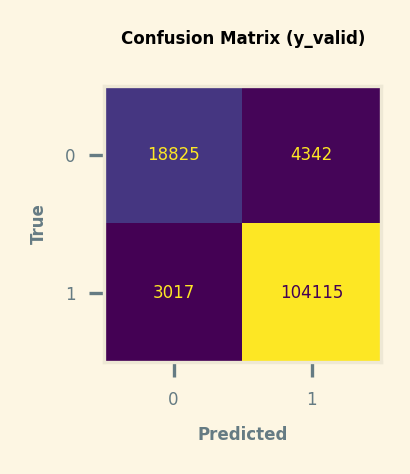

In [29]:
%%time

def RunModelv1():
    # Select subset of predictors
    X = pd.read_feather(f'{workdir}sba_final.csv.feather')
    y = X.pop('MIS_Status')

    model1 = process_model(X, y)   # Initiate class
    model1.split_data(0.7)         # Split data into train (70%), valid (15%), and test (15%)
    
    params = {'n_estimators': 1000, 'learning_rate': 0.05, 'max_depth': 6,
                               'tree_method':tree_method, 'early_stopping_rounds':100,
                               'eval_metric':['auc','error']}
    model1_results = model1.prep_run_model( "Metrics : Full SBA Not Oversampled",hyperparams=params)
    return model1_results
    
model1_results = RunModelv1()

<div class="alert alert-block alert-info">  
    Due to the imbalanced target data, the <b>Accuracy</b> metric is not suitable as it will favor the majority.  Instead, we use the <b>f1_score</b> metric, a balance of <b>precision</b> and <b>recall</b>.</b><br><br>
The f1_score here is good.  One technique for correcting imbalanced data is resampling.  Is there a benefit to resample our training data to fix the imbalance ?  Let's see when we get to the Model v3 section below.
</div>

<i><a style="color:DarkSlateGrey" href="#toc">Back to Table Of Contents</a></i>

<a id="model2"></a>
<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>3.2 Model v2</h2><br>
    With Undersampling.  Here we <b>undersample before splitting data</b>, as we are not adding any synthetic data. Since data will no longer imbalanced, we can use the <b>Accuracy metric</b>.
       </div>

In [76]:
%%time

def RunModelv2():
    X = pd.read_feather(f'{workdir}sba_final.csv.feather')
    y = X.pop('MIS_Status')
    
    model2 = process_model(X, y)
    model2.osample_Xy(os_class = 'rus')        #undersample
    model2.split_data(0.7)
    
    model2.X, model2.y = None, None
    del X, y
    gc.collect()
    sleep(3)
    
    model2_results = model2.prep_run_model("Metrics : SBA Undersampled", prt_acc = True)
    
    # save to files for reuse later
    model2_results['xg_model'].save_model(f'{workdir}modelv2_undersampling.json')
    joblib.dump(model2_results, f"{workdir}model2_results.dict")      
  
RunModelv2()

Our dataset after undersampling has <b>154451</b> rows. In theory, this is supposed to be a good size after undersampling - i.e. 10's of thousands, even over a hundred thousand.  The scores can be considered as very good too.<br><br>
However, we will implement oversampling too, and <b>use the whole dataset</b> in case some important insights were not included in the undersampled data.  At any rate, <b>we have saved this model</b> and can be used as a <b>backup model</b>, as well as a confirmation test for the next models which will be training oversampled data, especially with regards to <b>predictions for the minority class</b>. 

<i><a style="color:DarkSlateGrey" href="#toc">Back to Table Of Contents</a></i>

<a id="model3"></a>
<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>3.3 Model v3</h2><br>
    With Oversampling
       </div>

MIS_Status Count ->  1 : 714212, 0 : 154451


{'n_estimators': 1000,
 'learning_rate': 0.05,
 'max_depth': 6,
 'tree_method': 'hist',
 'early_stopping_rounds': 100,
 'eval_metric': ['auc', 'error'],
 'scale_pos_weight': 0.216253717383634}


Please wait, Fitting model can take time ...
Fitting model completed.

Preparing Predictions

Metrics : SBA Oversampled

y_valid RMSE    : 0.2771147916863274

y_valid f1 score: 95.18544180764863 %

--------------------------------------------------

Classification Report


,precision,recall,f1-score,support
0,0.722292,0.922951,0.810385,23167.0
1,0.982273,0.923263,0.951854,107132.0
macro avg,0.852283,0.923107,0.881120,130299.0
weighted avg,0.936049,0.923207,0.926701,130299.0



Confusion Matrix using Validation Data (y_valid)

True Negative  : CHGOFF (0) was predicted 21382 times correctly (72.23 %)
False Negative : CHGOFF (0) was predicted 8221 times incorrectly (27.77 %)
True Positive  : P I F (1) was predicted 98911 times correctly (98.23 %)
False Positive : P I F (1) was predicted 1785 times incorrectly (1.77 %)


,Metrics Summary: y_valid in %
rmse,0.277115
f1_score,95.185442
Precision,98.227338
Recall Sensitivity,92.326289
Recall Specificity,92.295075
G-Mean,92.310681


CPU times: total: 7min 17s
Wall time: 1min 6s


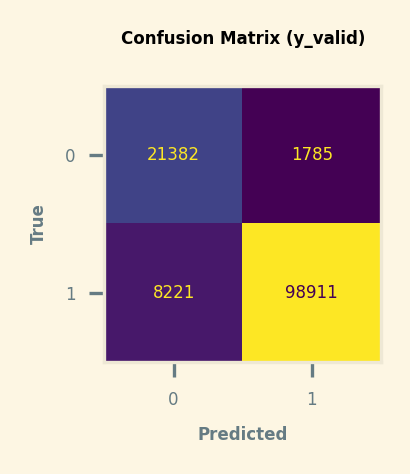

In [28]:
%%time

def RunModelv3():
    X = pd.read_feather(f'{workdir}sba_final.csv.feather')
    y = X.pop('MIS_Status')
    
    model3 = process_model(X, y)
    model3.split_data(0.7)
    '''
    Here, we can choose to oversample, or just use scale_pos_weight hyperparameter of XGBoost.
    Oversampling edges out the scale_pos_weight by a small margin, so we just use oversample.
    '''
    model3.osample(os_data=[1,0,0])
    #model3.upd_pos_weight()
    
    model3.X, model3.y = None, None
    del X, y
    gc.collect()
    sleep(3)
  
    model3_results = model3.prep_run_model("Metrics : SBA Oversampled")
    
    # save to files for reuse later
    model3_results['xg_model'].save_model(f'{workdir}modelv3.json')
    joblib.dump(model3_results, f"{workdir}model3_results.dict")      
    
    return model3_results
  
model3_results = RunModelv3()

<div class="alert alert-block alert-info">  
After oversampling, our f1_score is now lower than when not oversampled.  However, precision is now much higher, giving us <b>more confidence that the model is now better at predicting loans that will be approved</b>. This is what we want.  Even recall specificity, or True Negative Rate, is better.
</div>

**Next two cells are just comparing results of two different ways of loading a saved dictionary file.  Result should be the same.** 

In [93]:
# Plot feature importance
modelv3 = XGBClassifier()
modelv3.load_model(f'{workdir}modelv3.json')
print(f'{mf.color.bdblue}Hyperparameter values{mf.color.end}')
display(modelv3.get_xgb_params())

mf.plot_features(modelv3, (8,7))

<div class="alert alert-block alert-info">
    <b>Observation</b><br>
    I was hoping to see <b>Industry</b> at a much higher position here, but apparently the incomplete data on industry had an effect.<br><br>
Furthermore, <b>Recession</b> has to be at a very high position, but is at the bottom instead.  This could be due to <b>Recession</b> data being highly skewed towards 1 (Not Recession).<br><br>
<b>Real Estate</b> should have good importance too, but it may be highly skewed as well.

In [94]:
model3_results = joblib.load(f"{workdir}model3_results.dict")

mf.plot_features(model3_results['xg_model'], (8,7))

<i><a style="color:DarkSlateGrey" href="#toc">Back to Table Of Contents</a></i>

<a id="test_model"></a>
<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 20px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>4. Test Model</h2>
    </div>
    

<a id="test_test_dataset"></a>
<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 20px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>4.1 Test Model with Test Dataset</h2>
    Test Dataset was previously unseen by the model.
    </div>

In [95]:
def Modelv3WithTestData():
    X_test = model3_results['X_test']
    y_test = model3_results['y_test']
    
    # Get predictions
    predictions = modelv3.predict(X_test)
    #mf.model_eval(y_test, predictions);
    mf.model_eval2(modelv3,
                   model3_results['X_train'], model3_results['y_train'],
                   X_test, y_test,
                   cmDisplay=True, prtstr = 'y_test')
    
Modelv3WithTestData()

<a id="test_user_input"></a>
<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 20px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>4.2 Test Model with User Input</h2>
    </div>

<div class="alert alert-block alert-info">So let's assume the following are <b>the entries of a user</b>, through a user interface, looking for a prediction from our model.</div>

In [96]:
def UserInputTest():
    # 16 entries
    user_input =   {'Term':50, 
                    'NoEmp':0,
                    'NewExist':1,
                    'CreateJob':0 ,          
                    'RetainedJob':0,         
                    'FranchiseCode':1,       
                    'UrbanRural':0,           
                    'LowDoc':0,               
                    'DisbursementGross':50000,                 
                    'SBA_Appv':25000,          
                    'Industry':71, 
                    'Recession':0,
                    'RealEstate':0,           
                    'SBA_Portion':50,
                    'City':'EVANSVILLE',
                    'State':'IN'
                   }

    city = user_input['City']
    state = user_input['State']
    city_state = f'{city}_{state}'

    state_hash = int(hashlib.sha1(('State' + "_" + \
                              str(state)).encode('utf-8')).hexdigest(), 16) % 900000
    city_state_hash = int(hashlib.sha1(('CityState' + "_" + \
                              str(city_state)).encode('utf-8')).hexdigest(), 16) % 900000

    print(f'State_hash = {state_hash}')
    print(f'CityState_hash = {city_state_hash}')

    user_input.pop('City')
    user_input.pop('State')
    user_input['State_hash'] = state_hash
    user_input['CityState_hash'] = city_state_hash

    user_input_list = list(user_input.values())
    
    return {'user_input':user_input, 'user_input_list':user_input_list}

user_input_param = UserInputTest()

print()
print(f"{mf.color.bold}User Entry:{mf.color.end}")
user_input_param['user_input']

In [97]:
# User Input test 1
def UserInputTest1():
    features = np.array([user_input_param['user_input_list']])   

    # using inputs to predict the output
    pred = modelv3.predict(features)
    if pred[0] == 1:
        print(f'{mf.color.bdblue}Prediction: Approve The Loan{mf.color.end}')
    else:
        print(f'{mf.color.bdred}Prediction: Do Not Approve The Loan{mf.color.end}')
        
UserInputTest1()
print(f'Correct answer is: {mf.color.bold}Do Not Approve{mf.color.end}')

In [98]:
# User Input test 2
def UserInputTest2():
    '''
    # if one wants to edit the list from the previous cell
    user_input2_list = user_input_list[:]   # make a copy
    user_input2_list[0] = 500          # change term 
    '''

    user_input2 = copy.deepcopy(user_input_param['user_input'])
    user_input2['Term'] = 500     # change term
    user_input2_list = list(user_input2.values())

    features = np.array([user_input2_list]) 

    # using inputs to predict the output
    pred = modelv3.predict(features)
    if pred[0] == 1:
        print(f'{mf.color.bdblue}Prediction: Approve The Loan{mf.color.end}')
    else:
        print(f'{mf.color.bdred}Prediction: Do Not Approve The Loan{mf.color.end}')
        
UserInputTest2()
print(f'Correct answer is: {mf.color.bold}Approve{mf.color.end}')

<div style="font-family: Trebuchet MS;background-color:HoneyDew;color:Black;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;border: 5px solid CadetBlue;"><b>Predictions:</b><br>
    
- 1 -> can approve<br>
- 0 -> do not approve<br>

Of course, in real life, will need to check further using other data (e.g. financial statements, kind of real estate, etc.) or other data's models if available.

In [99]:
del user_input_param
gc.collect()

<a id="test_user_input"></a>
<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 20px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>4.3 Test Model with Full Dataset</h2>
    </div>

In [100]:
def Modelv3TestFull():
    X = pd.read_feather(f'{workdir}sba_final.csv.feather')
    y = X.pop('MIS_Status')
    
    fd = process_model(X, y)
    #fd.osample_Xy()
    
    modelv3 = XGBClassifier()
    modelv3.load_model(f'{workdir}modelv3.json')
    
    # Get predictions
    predictions = modelv3.predict(fd.X)
    #mf.model_eval(fd.y, predictions) 
    mf.model_eval2(modelv3,
                   model3_results['X_train'], model3_results['y_train'],
                   X, y,
                   cmDisplay=True, prtstr = 'y_test')
  
Modelv3TestFull()

<i><a style="color:DarkSlateGrey" href="#toc">Back to Table Of Contents</a></i>

<a id="mutual_info"></a>
<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 20px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>5. Mutual Information Scores</h2>
 "A general-purpose metric, normally used before selecting and building a model, but used here in the end, for comparison.  Mutual information is a lot like correlation in that it measures a relationship between two quantities. The advantage of mutual information is that it can detect any kind of relationship, while correlation only detects linear relationships."
    </div>

In [101]:
%%time

def GetMIScores():
    X = pd.read_feather(f'{workdir}sba_final.csv.feather')
    y = X.pop('MIS_Status')

    model_mi = process_model(X, y)
    model_mi.osample_Xy()
    
    del X,y
    gc.collect()
    sleep(3)
    
    mi_scores = mf.make_mi_scores(model_mi.X, model_mi.y)

    print()
    
    return mi_scores

mi_scores = GetMIScores()

In [102]:
plt.figure(dpi=300, figsize=(8, 5))
mf.plot_mi_scores(mi_scores)

In [103]:
# Plot feature importance

mf.plot_features(modelv3, (8,7))

In [104]:
del mi_scores
gc.collect()

In [105]:
if alert_flag == 1:
    if kaggle_flag == 0:   # not Kaggle
        engine.say("SBA Mutual Information completed.")
        engine.runAndWait()
    else:
        display(Audio(url=audio_path, autoplay=True))

<div class="alert alert-block alert-info">
The importance ranked by <b>Mutual Information</b> and <b>XGBoost Feature Importance</b> metrics are different.  Which ranking do you think is more reasonable ?</div>

<i><a style="color:DarkSlateGrey" href="#toc">Back to Table Of Contents</a></i>

<a id="trim_dataset"></a>
<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 20px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>6. Trim Dataset</h2><br>
After the preprocessing and encoding steps, not all of the features may be useful in forecasting the loan default. Alternatively we can select the <b>top 5 or top 8 features</b>, based on the feature importance plot above, which had a major contribution in forecasting loan defaults.<br><br>

If the model performance is similar in both the cases, that is – by using all the features and by using 5-8 features, then we should use only the top 8 features, in order to keep the model simpler and more efficient.

The idea is to have a less complex model without compromising on the overall model performance.
</div>

In [117]:
X = pd.read_feather(f'{workdir}sba_final.csv.feather')
y = X.pop('MIS_Status')

#Let's retain the top 8 from Mutual Information metric 
mi_features = ['Term', 'DisbursementGross', 'SBA_Appv', 'SBA_Portion',
                'CityState_hash', 'FranchiseCode', 'RealEstate', 'UrbanRural']

Xmi = X[mi_features]

#Let's retain the top 8 from Feature Importance metric 
fi_features = ['Term', 'State_hash', 'SBA_Appv', 'DisbursementGross', 'CityState_hash',
                'Industry', 'NoEmp', 'SBA_Portion']

Xfi = X[fi_features]

del X
gc.collect();

In [118]:
%%time

def ModelMI():
    model_mi = process_model(Xmi, y)
    model_mi.split_data(0.7)
    model_mi.osample(os_data=[1,0,0])
  
    model_mi_results = model_mi.prep_run_model("Mutual Information Metrics")
    
    print()
    return model_mi_results

model_mi_results = ModelMI()

In [119]:
# Plot mutual information
my_model_mi = model_mi_results['xg_model']

mf.plot_features(my_model_mi, (8,7))

In [121]:
# Test with Unseen test data
def MI_Model_On_Test_Data():
    X_test = model_mi_results['X_test']
    X_test_mi = X_test[mi_features]

    y_test = model_mi_results['y_test']

    predictions_mi = my_model_mi.predict(X_test_mi)
    #mf.model_eval(y_test, predictions_mi)
    mf.model_eval2( model_mi_results['xg_model'],
                    model_mi_results['X_train'], model_mi_results['y_train'],
                    model_mi_results['X_test'], model_mi_results['y_test'],
                    cmDisplay=True)
    print()
    
MI_Model_On_Test_Data()

In [110]:
del Xmi, mi_features, my_model_mi, model_mi_results
gc.collect();

In [122]:
%%time

def ModelFI():
    model_fi = process_model(Xfi, y)
    model_fi.split_data(0.7)
    model_fi.osample(os_data=[1,0,0])
    
    model_fi_results = model_fi.prep_run_model("Feature Importance Metrics")

    print()
    return model_fi_results
    
model_fi_results = ModelFI()

In [123]:
# Plot feature importance
my_model_fi = model_fi_results['xg_model']

mf.plot_features(my_model_fi, (8,7))

In [124]:
# Test with Unseen test data
def FI_Model_On_Test_Data():
    X_test = model_fi_results['X_test']
    X_test_fi = X_test[fi_features]

    y_test = model_fi_results['y_test']

    predictions_fi = my_model_fi.predict(X_test_fi)
    mf.model_eval2( model_fi_results['xg_model'],
                    model_fi_results['X_train'], model_fi_results['y_train'],
                    model_fi_results['X_test'], model_fi_results['y_test'],
                    cmDisplay=True)
    print()
    
FI_Model_On_Test_Data()

In [114]:
del Xfi, fi_features, my_model_fi, model_fi_results, y
del model3_results, modelv3
gc.collect()

<a id="results1"></a>
<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 20px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>7. Full or Trimmed Dataset</h2>
</div>

<div class="alert alert-block alert-info">
    <b>Do we select the full dataset, or the trimmed dataset ?</b><br><br>
    We can <b>stick with the full features</b> for now; but the trimmed features are also good, with the <b>Manual Information trimmed dataset</b> very slightly favored.

<i><a style="color:DarkSlateGrey" href="#toc">Back to Table Of Contents</a></i>

In the next notebook, we <b>optimize</b> our XGBoost hyperparameters with <b>Optuna</b>.<br><br>
<a style="color:DarkSlateGrey;font-size:20px" href="https://www.kaggle.com/code/josephramon/sba-optuna-xgboost-random-forest" target="_blank"><b>Optuna Hyperparameter Tuning</b></a>